# Automatic Sensor Dust Detection and Inpainting

In [1]:
#import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

from shapedetector import ShapeDetector
import imutils

## Load Image for Inpainting

In [2]:
#load images
img_path = 'dust_photos/images/hawaii - 29.jpg'
#color version
cimg = cv2.imread(img_path)
#grey scale image
img = cv2.imread(img_path,0)

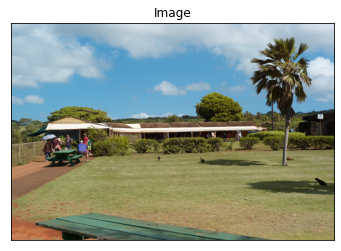

In [3]:
#Show and Save Original Color Image
cv2.imwrite('original_image.png', cimg)

plt_image = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)
plt.imshow(plt_image)
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.show()

## Apply Thresholds to the Image

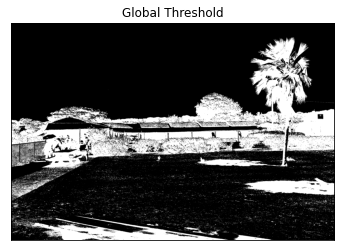

In [4]:
#Apply Global Threshold
m = np.mean(img, dtype=int)
global_thresh = cv2.threshold(img,int(m/1.2),255,cv2.THRESH_BINARY_INV)[1]

#Show and Save Global Threshold Image
cv2.imwrite('global_threshold.png', global_thresh) 

plt.imshow(global_thresh, 'gray')
plt.title('Global Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

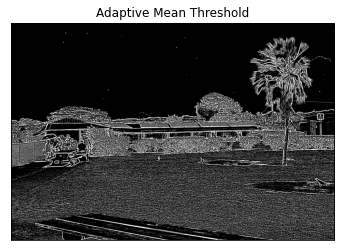

In [5]:
#Perform Adaptive Threshold
#adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,27,15)
adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19,10)
#adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,5)
#adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,5,2)


#Show and Save Adaptive Threshold Image
cv2.imwrite('adapt_mean_threshold.png', adaptive_thresh_img)  

plt.imshow(adaptive_thresh_img, 'gray')
plt.title('Adaptive Mean Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

## Filter the Thresholded Image with Magnification Filter

In [6]:
#Image Magnification Filter Kernel
KERNEL = np.ones((10,10), dtype=int)*10

print(KERNEL)

[[10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]]


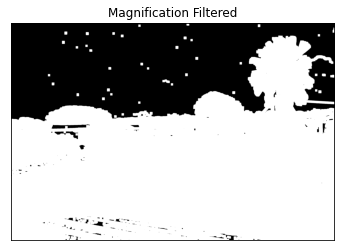

In [7]:
#Filter the thresholded images*
img_filt = cv2.filter2D(adaptive_thresh_img,-1,KERNEL)
#global_thresh = cv2.filter2D(global_thresh,-1,KERNEL)

#Apply multiple times
for i in range(2):
    KERNEL_i = np.ones((int(10),int(10)), dtype=int)*10
    img_filt = cv2.filter2D(img_filt,-1,KERNEL_i)

#Show and Save Magnification Image
cv2.imwrite('mag_filt.png', img_filt)    

plt.imshow(img_filt, 'gray')
plt.title('Magnification Filtered'), plt.xticks([]), plt.yticks([])
plt.show()

## Combine the Thresholds Together

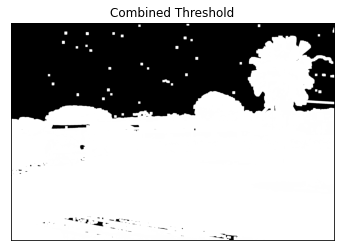

In [8]:
#Combine Thresholds
comb = img_filt + global_thresh

#Show and Save Combined Threshold Image
cv2.imwrite('comb_threshold.png', comb)

plt.imshow(comb, 'gray')
plt.title('Combined Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

## Find and Classify the Contours in the Image

In [9]:
#Find and Classify Contours of Image
cnts = cv2.findContours(comb.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

cimg_copy = cimg.copy()

for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int((M["m10"] / M["m00"]) * 1)
        cY = int((M["m01"] / M["m00"]) * 1)
        shape = sd.detect(c)
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape on the image
        if len(c) < 50:
            c = c.astype("float")
            c *= 1
            c = c.astype("int")
            cv2.drawContours(cimg_copy, [c], -1, (0, 255, 0), 2)
            cv2.putText(cimg_copy, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 2)

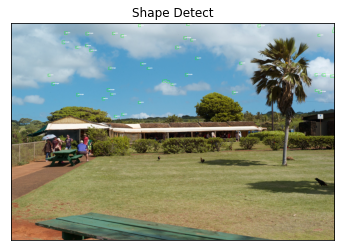

In [10]:
#Show and Save Detected Contours
cv2.imwrite('shape_detect.png', cimg_copy)

plt_cimage = cv2.cvtColor(cimg_copy, cv2.COLOR_BGR2RGB)
plt.imshow(plt_cimage)
plt.title('Shape Detect'), plt.xticks([]), plt.yticks([])
plt.show()

## Create the Inpainting Mask based on the Detected Contours

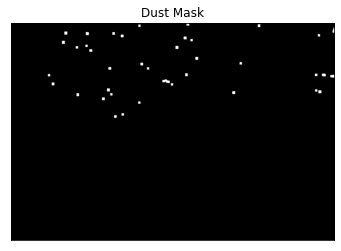

In [11]:
#Create Dust Mask
img_mask = np.zeros((img.shape[0], img.shape[1]), dtype='uint8')
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int((M["m10"] / M["m00"]) * 1)
        cY = int((M["m01"] / M["m00"]) * 1)
        shape = sd.detect(c)
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape on the image
        if len(c) < 50:
            c = c.astype("float")
            c *= 1
            c = c.astype("int")
            cv2.fillPoly(img_mask, pts=[c], color=(255,255,255))

#Show and Save Mask Image
cv2.imwrite('dust_mask.png', img_mask)
plt.imshow(img_mask, 'gray')
plt.title('Dust Mask'), plt.xticks([]), plt.yticks([])
plt.show()

## Perform Inpainting

In [12]:
#Set inpainting options
radius = 10
flags = cv2.INPAINT_TELEA #or use cv2.INPAINT_NS

In [13]:
#Inpaint the image
cimg_inpaint = cv2.inpaint(cimg, img_mask, radius, flags=flags)

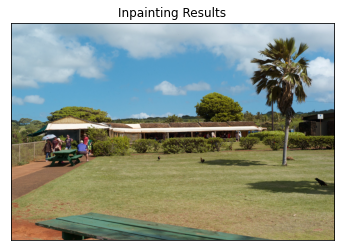

In [14]:
#Show and Save Final Image
cv2.imwrite('auto_dust_inpainting.png', cimg_inpaint)

plt_out = cv2.cvtColor(cimg_inpaint, cv2.COLOR_BGR2RGB)
plt.imshow(plt_out)
plt.title('Inpainting Results'), plt.xticks([]), plt.yticks([])
plt.show()